In [1]:
from pathlib import Path
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import IsolationForest
from umap import UMAP
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import hdbscan
from datetime import datetime

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/pyth

In [2]:
!pwd

/Users/adityabehal/Documents/RPI/Junior/Summer/UCSF/Shirvalkar-Lab/clustering


In [3]:
pt_id = "RCS07"

In [4]:
IMAGES_PATH = Path() / "data" / pt_id
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
pt_pain_path = Path() / "data" / pt_id / (pt_id + "_pain_filtered.xlsx")
pt_sleep_path = Path() / "data" / pt_id / (pt_id + "_sleepStageLogInfo_20190130_20230530.csv")
pt_wear_path = Path() / "data" / pt_id / (pt_id + "_fitbitWearTimeViaHR_20190130_20230530.csv")

pt_pain = pd.read_excel(pt_pain_path)
pt_sleep = pd.read_csv(pt_sleep_path)
pt_wear = pd.read_csv(pt_wear_path)

In [6]:
# convert a StartTime to a relative start time (see the cell below)
def convert_to_fractional_time(time_string):
    time_parts = time_string.split(' ')[-2].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    am_pm = time_string.split(' ')[-1].strip().upper()

    if am_pm == 'PM' and hours != 12:
        hours += 12
    elif am_pm == 'AM' and hours == 12:
        hours = 0

    fractional_hours = hours + (minutes / 60.0) + (seconds / 3600.0)

    if fractional_hours >= 24:
        fractional_hours -= 24

    return fractional_hours

In [7]:
# extract just the Day from the StartTime field and store it in a separate column
pt_sleep["Day"] = pt_sleep["StartTime"].str.split().str[0]

# binarize SleepDataType --> classic = 0, stages = 1
pt_sleep["SleepDTBinary"] = LabelEncoder().fit_transform(pt_sleep["SleepDataType"])

# we'll also convert times in StartTime to relative start times 
# (i.e. ignore the day and just look at the HH:MM:SS AM/PM and convert it into a number ranging from 0 - 24 hours)
pt_sleep["RelativeStartTime"] = pt_sleep["StartTime"].apply(convert_to_fractional_time)

# get rid of days with 0 perrcent wear time
pt_wear = pt_wear[pt_wear["PercentageWearTime"] != 0]

# merge sleep and wear dataframes with SQL-like inner join
pt_sleep_wear = pd.merge(pt_sleep, pt_wear, on="Day", how="inner")

# shorten some column names to improve plotting aesthetics 
pt_sleep_wear.columns = pt_sleep_wear.columns.str.replace("Classic", "C-")
pt_sleep_wear.columns = pt_sleep_wear.columns.str.replace("Stages", "S-")

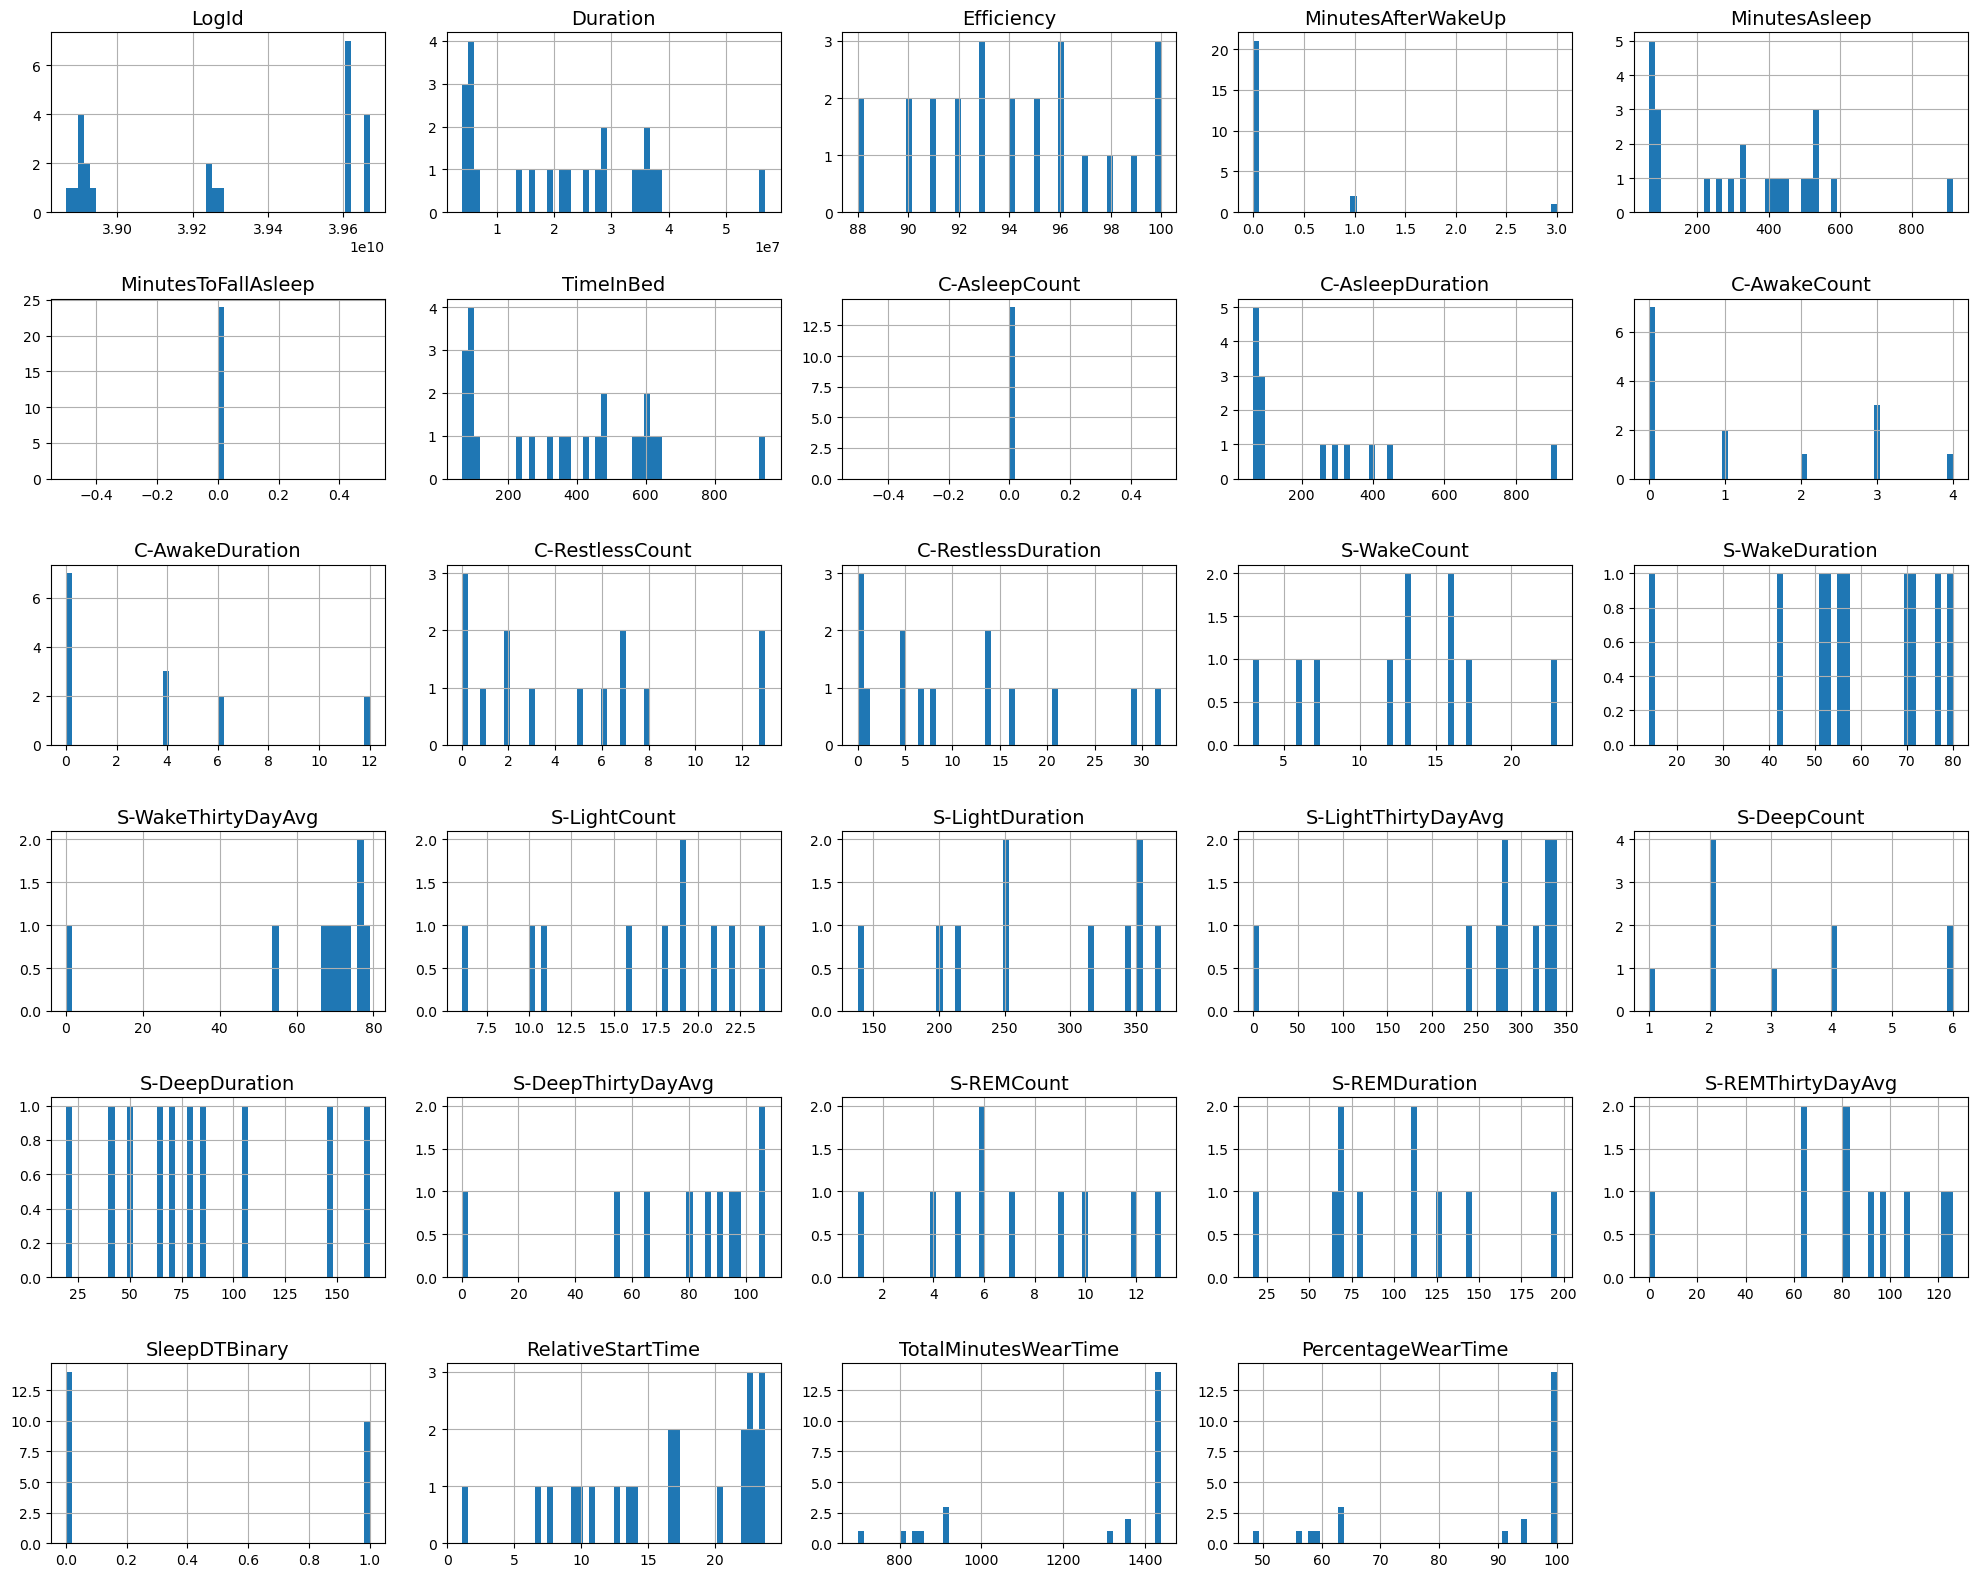

In [8]:
# the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# let's get histograms of the data variables
pt_sleep_wear.hist(bins=50, figsize=(20, 16))
plt.tight_layout()
save_fig((pt_id + "_sleep_histogram_plots"))
plt.show()

In [9]:
# let's get a sense of the number and data types of the dataframe columns
pt_sleep_wear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LogId                 24 non-null     int64  
 1   StartTime             24 non-null     object 
 2   Duration              24 non-null     int64  
 3   Efficiency            24 non-null     int64  
 4   IsMainSleep           24 non-null     bool   
 5   SleepDataType         24 non-null     object 
 6   MinutesAfterWakeUp    24 non-null     int64  
 7   MinutesAsleep         24 non-null     int64  
 8   MinutesToFallAsleep   24 non-null     int64  
 9   TimeInBed             24 non-null     int64  
 10  C-AsleepCount         14 non-null     float64
 11  C-AsleepDuration      14 non-null     float64
 12  C-AwakeCount          14 non-null     float64
 13  C-AwakeDuration       14 non-null     float64
 14  C-RestlessCount       14 non-null     float64
 15  C-RestlessDuration    14 

In [10]:
# we'll consider data as reliable if the wear time for that day was more than 80 percent and if it was auto-detected
pt_sleep_wear = pt_sleep_wear[pt_sleep_wear["PercentageWearTime"] >= 80]
pt_sleep_wear = pt_sleep_wear[pt_sleep_wear["SleepLogType"] == "auto_detected"]

In [11]:
# let's get a sense of our filtered data by looking at the first 5 rows
pt_sleep_wear.head()

LogId               StartTime  Duration  Efficiency  IsMainSleep  \
1  38887908898  10/27/2022 10:53:30 PM  36240000          91         True   
2  38898667160   10/28/2022 5:00:30 PM   5820000          93        False   
3  38898667161   10/28/2022 8:13:00 PM   5220000          91        False   
4  38898667162  10/28/2022 11:24:30 PM  35460000          90         True   
5  38910689883  10/29/2022 10:24:30 PM  36900000          92         True   

  SleepDataType  MinutesAfterWakeUp  MinutesAsleep  MinutesToFallAsleep  \
1        stages                   0            532                    0   
2       classic                   0             90                    0   
3       classic                   0             79                    0   
4        stages                   1            540                    0   
5        stages                   0            535                    0   

   TimeInBed  ...  S-DeepThirtyDayAvg  S-REMCount  S-REMDuration  \
1        604  ...                87.0        12.0           68.0   
2         97  ...                 NaN         NaN            NaN   
3         87  ...                 NaN         NaN            NaN   
4        591  ...               107.0        13.0          127.0   
5        615  ...                97.0         4.0           81.0   

   S-REMThirtyDayAvg   SleepLogType         Day  SleepDTBinary  \
1               64.0  auto_detected  10/27/2022              1   
2                NaN  auto_detected  10/28/2022              0   
3                NaN  auto_detected  10/28/2022              0   
4               65.0  auto_detected  10/28/2022              1   
5               81.0  auto_detected  10/29/2022              1   

   RelativeStartTime  TotalMinutesWearTime  PercentageWearTime  
1          22.891667                  1440               100.0  
2          17.008333                  1440               100.0  
3          20.216667                  1440               100.0  
4          23.408333                  1440               100.0  
5          22.408333                  1440               100.0  

[5 rows x 34 columns]

In [12]:
# let's get a sense of the number and data types of the filtered dataframe columns
pt_sleep_wear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 1 to 23
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LogId                 17 non-null     int64  
 1   StartTime             17 non-null     object 
 2   Duration              17 non-null     int64  
 3   Efficiency            17 non-null     int64  
 4   IsMainSleep           17 non-null     bool   
 5   SleepDataType         17 non-null     object 
 6   MinutesAfterWakeUp    17 non-null     int64  
 7   MinutesAsleep         17 non-null     int64  
 8   MinutesToFallAsleep   17 non-null     int64  
 9   TimeInBed             17 non-null     int64  
 10  C-AsleepCount         8 non-null      float64
 11  C-AsleepDuration      8 non-null      float64
 12  C-AwakeCount          8 non-null      float64
 13  C-AwakeDuration       8 non-null      float64
 14  C-RestlessCount       8 non-null      float64
 15  C-RestlessDuration    8 n

In [13]:
# let's get summary statistics of the filtered dataframe columns
pt_sleep_wear.describe()

LogId      Duration  Efficiency  MinutesAfterWakeUp  \
count  1.700000e+01  1.700000e+01   17.000000           17.000000   
mean   3.920247e+10  2.158941e+07   93.176471            0.294118   
std    3.180524e+08  1.296256e+07    3.557304            0.771744   
min    3.888791e+10  4.140000e+06   88.000000            0.000000   
25%    3.891069e+10  5.820000e+06   91.000000            0.000000   
50%    3.923980e+10  2.220000e+07   93.000000            0.000000   
75%    3.962009e+10  3.546000e+07   95.000000            0.000000   
max    3.966970e+10  3.852000e+07  100.000000            3.000000   

       MinutesAsleep  MinutesToFallAsleep   TimeInBed  C-AsleepCount  \
count      17.000000                 17.0   17.000000            8.0   
mean      323.058824                  0.0  359.823529            0.0   
std       190.234878                  0.0  216.042599            0.0   
min        68.000000                  0.0   69.000000            0.0   
25%        94.000000                  0.0   97.000000            0.0   
50%       326.000000                  0.0  370.000000            0.0   
75%       523.000000                  0.0  591.000000            0.0   
max       589.000000                  0.0  642.000000            0.0   

       C-AsleepDuration  C-AwakeCount  ...  S-DeepCount  S-DeepDuration  \
count          8.000000      8.000000  ...     9.000000        9.000000   
mean         172.375000      1.000000  ...     2.888889       83.111111   
std          130.470508      1.414214  ...     1.536591       48.678651   
min           68.000000      0.000000  ...     1.000000       19.000000   
25%           78.500000      0.000000  ...     2.000000       50.000000   
50%           92.000000      0.500000  ...     2.000000       69.000000   
75%          273.500000      1.250000  ...     4.000000      107.000000   
max          389.000000      4.000000  ...     6.000000      166.000000   

       S-DeepThirtyDayAvg  S-REMCount  S-REMDuration  S-REMThirtyDayAvg  \
count            9.000000    9.000000       9.000000           9.000000   
mean            87.000000    7.333333     102.444444          92.666667   
std             18.034689    3.937004      52.019494          22.388613   
min             54.000000    1.000000      17.000000          64.000000   
25%             80.000000    5.000000      68.000000          81.000000   
50%             91.000000    6.000000     113.000000          91.000000   
75%             97.000000   10.000000     127.000000         107.000000   
max            107.000000   13.000000     196.000000         126.000000   

       SleepDTBinary  RelativeStartTime  TotalMinutesWearTime  \
count      17.000000          17.000000             17.000000   
mean        0.529412          17.224020           1423.882353   
std         0.514496           6.896758             36.876284   
min         0.000000           1.083333           1321.000000   
25%         0.000000          13.600000           1440.000000   
50%         1.000000          20.216667           1440.000000   
75%         1.000000          22.741667           1440.000000   
max         1.000000          23.425000           1440.000000   

       PercentageWearTime  
count           17.000000  
mean            98.880719  
std              2.560853  
min             91.736111  
25%            100.000000  
50%            100.000000  
75%            100.000000  
max            100.000000  

[8 rows x 29 columns]

In [14]:
# code adapted from https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another
# we will use kendall tau rank correlation as it more robust to outliers than spearman's rank correlation

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'kendall')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.kendalltau(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=70)
    
def plotcorr(data):
    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(data, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)
    g.map_upper(corrfunc)

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

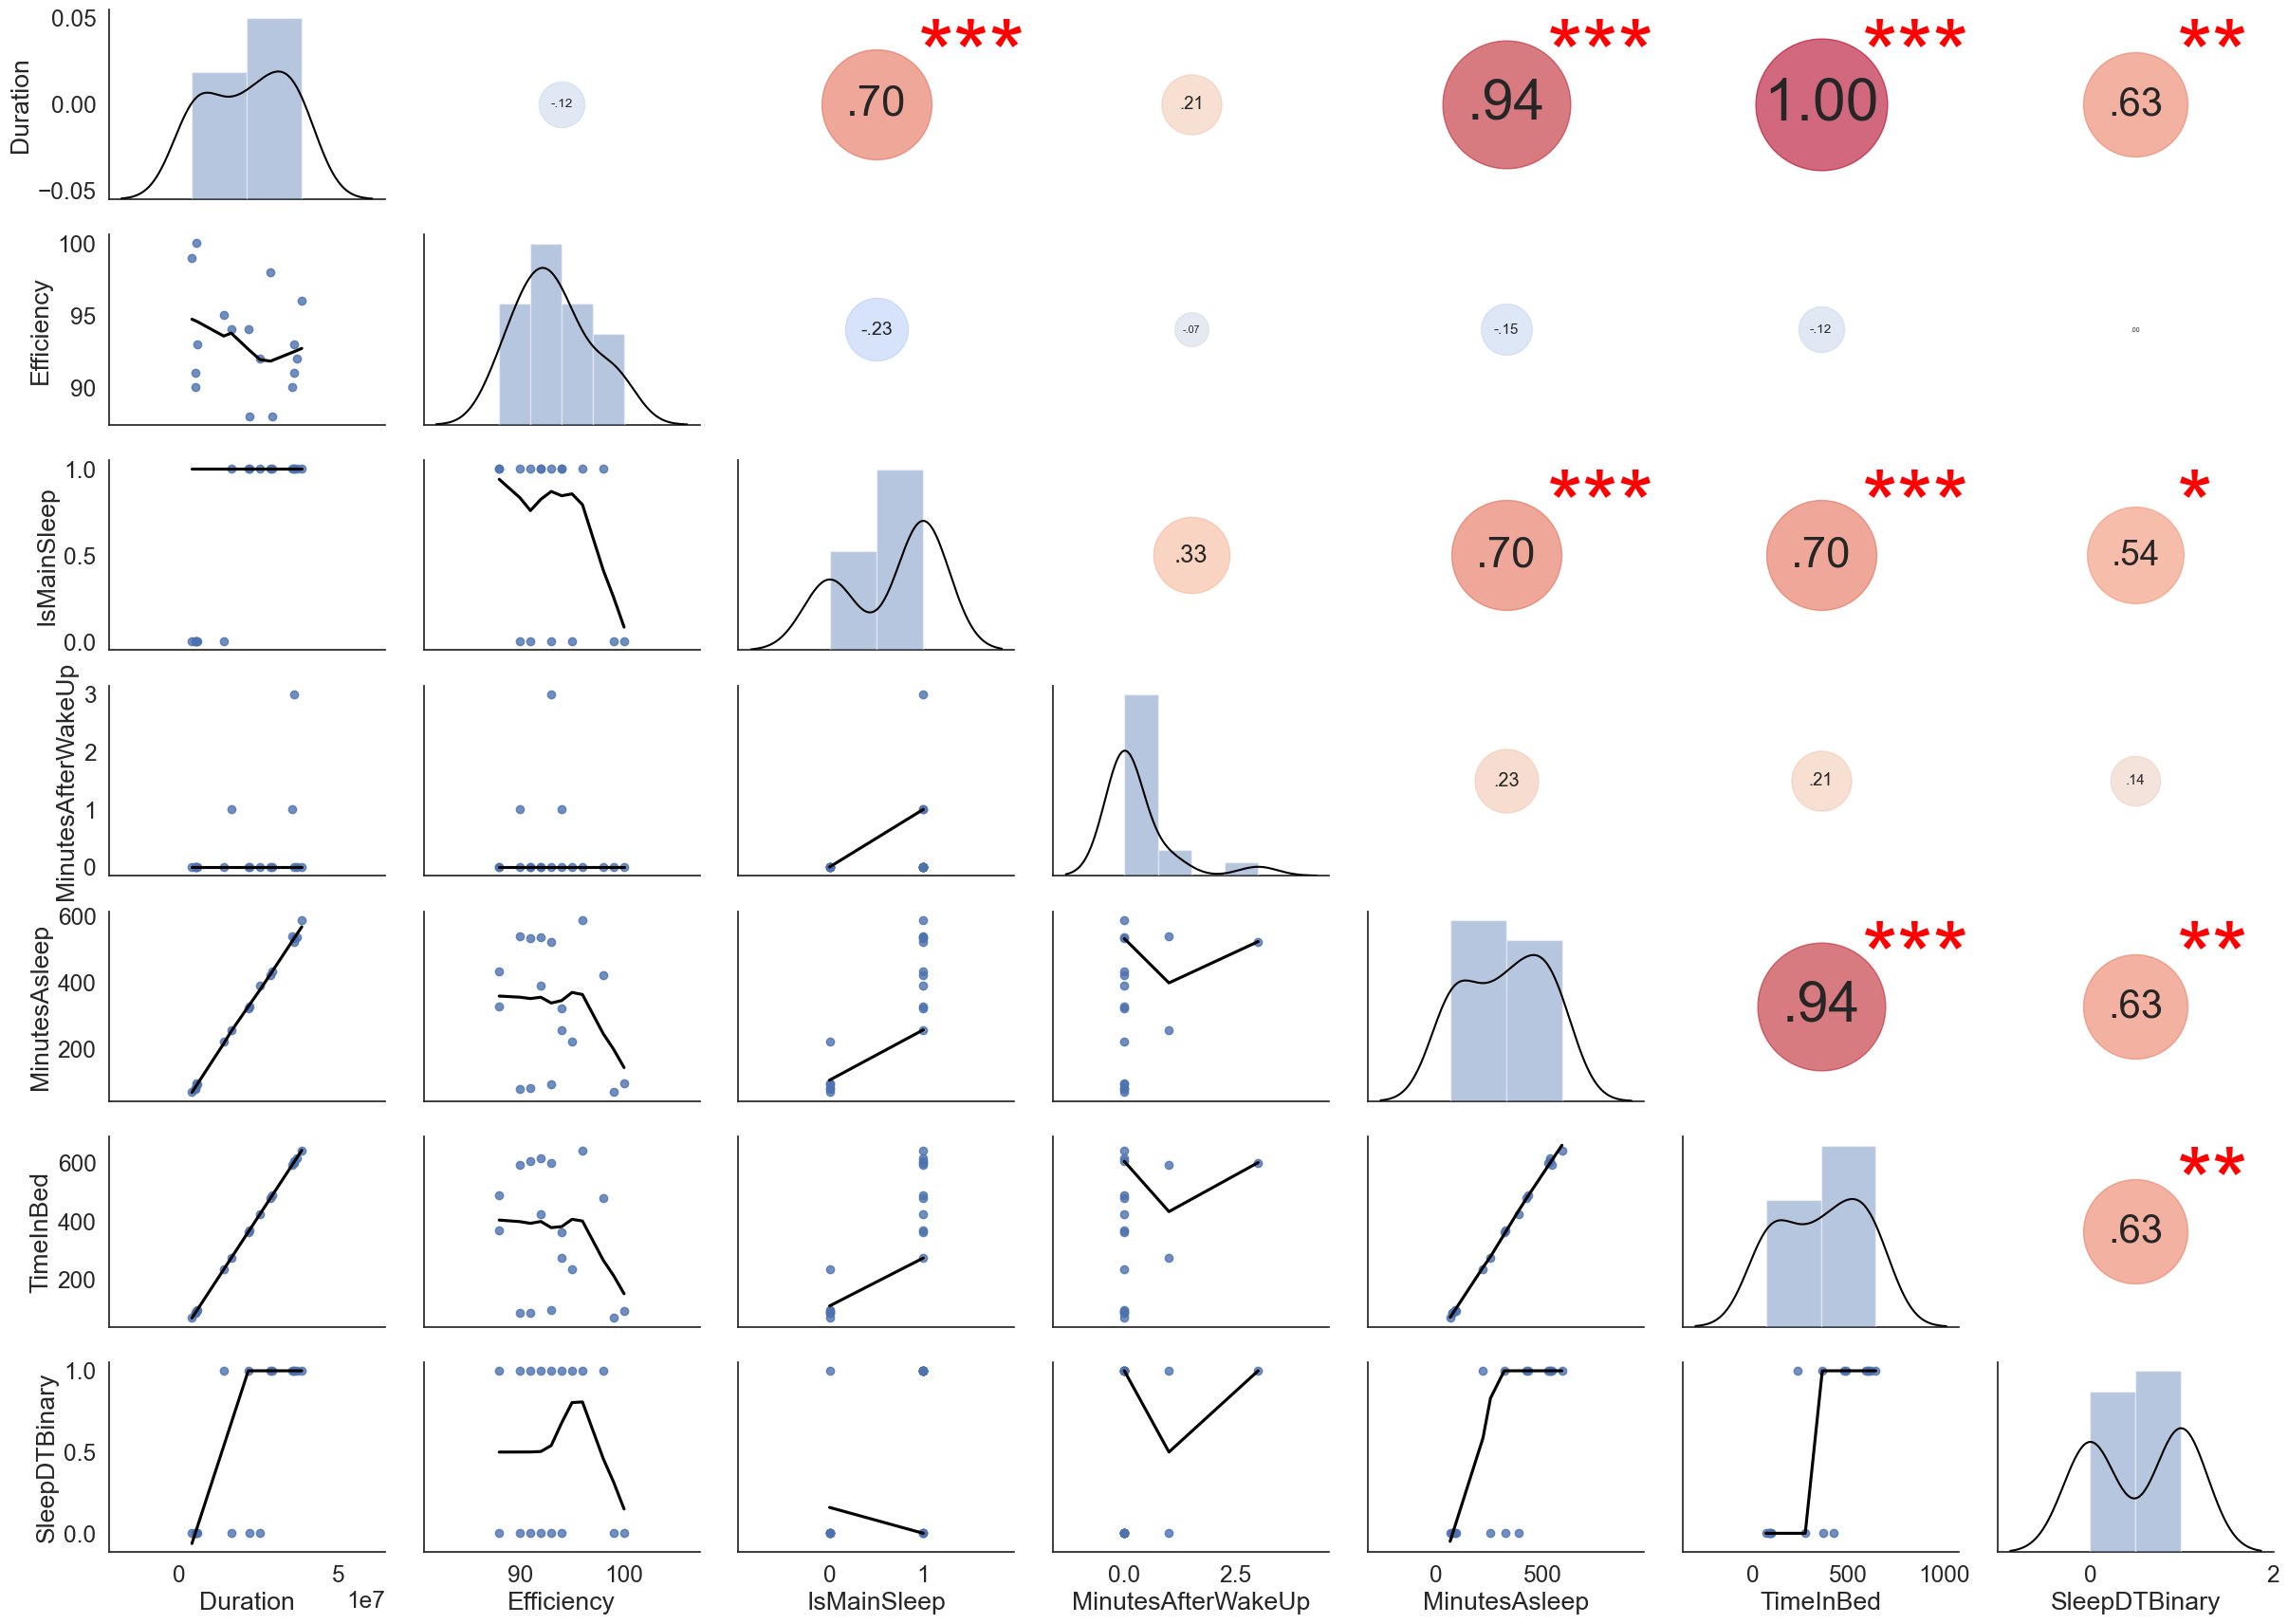

In [15]:
# let's see how well pairwise combinations of general features correlate with each other
pt_sleep_wear_scatter_all = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 30]]

plotcorr(pt_sleep_wear_scatter_all)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_all"))

plt.show()

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

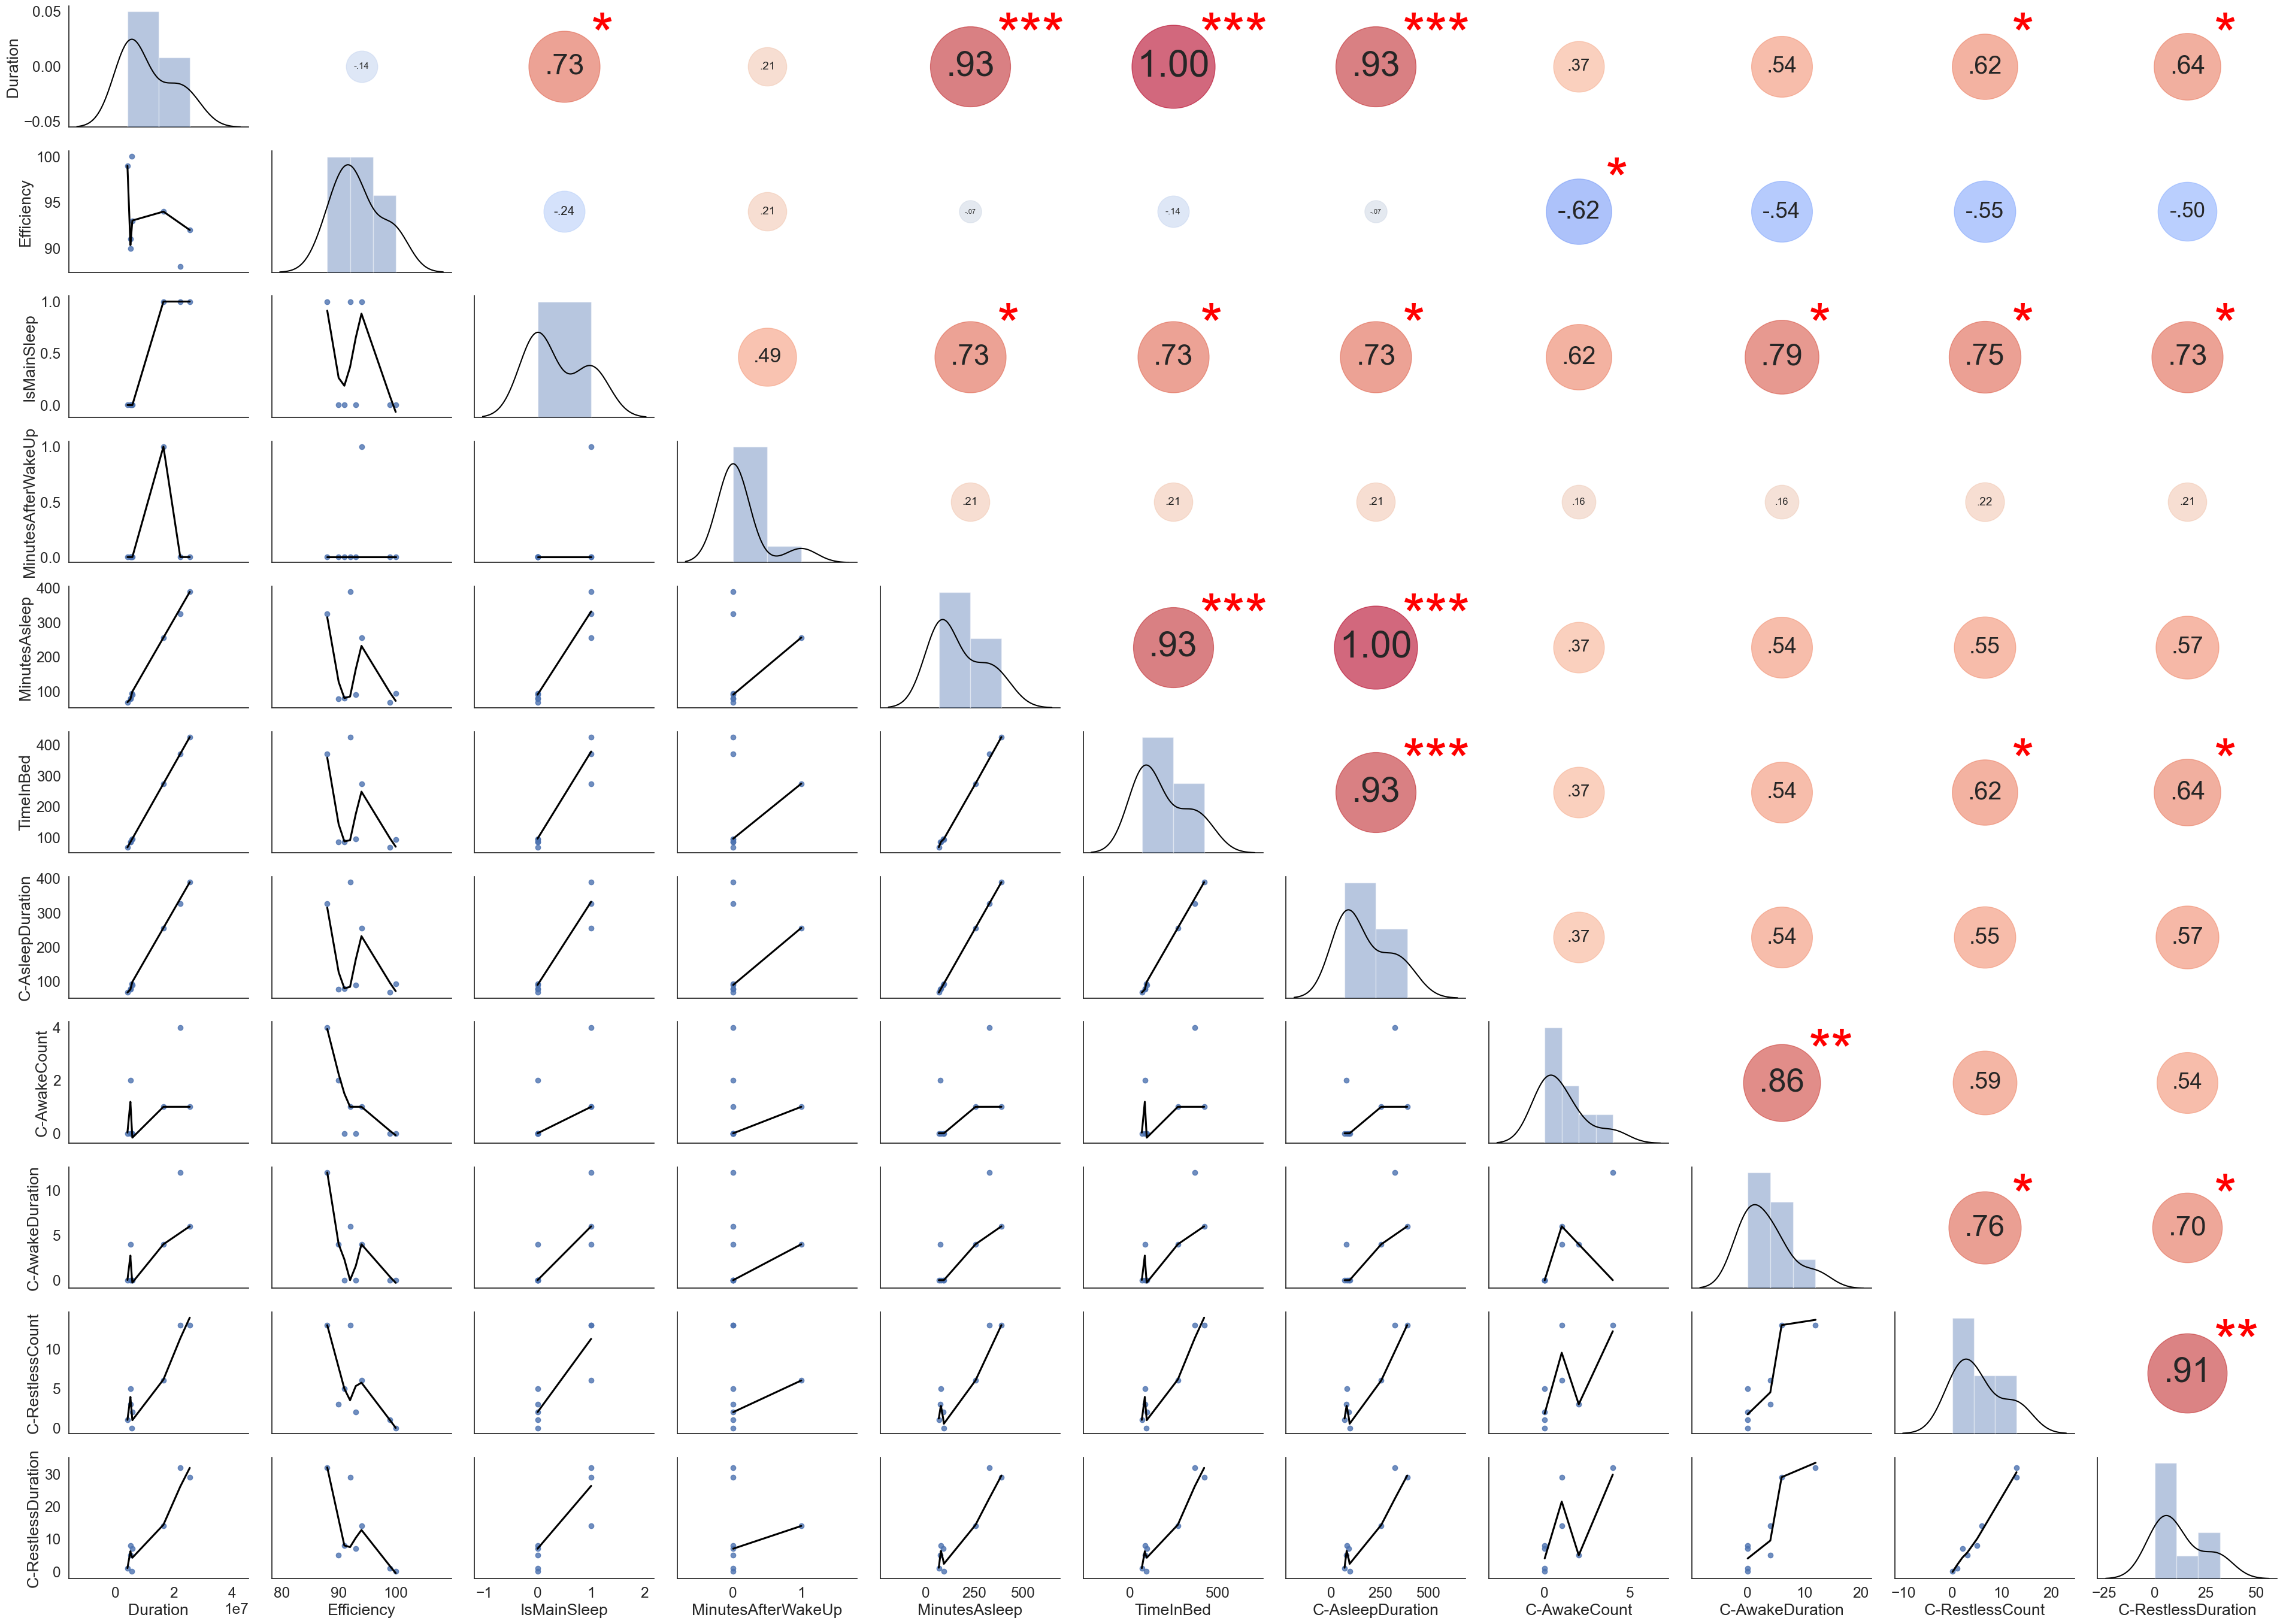

In [16]:
# let's see how well pairwise combinations of classic features correlate with each other
pt_sleep_wear_scatter_classic = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15]].dropna()

plotcorr(pt_sleep_wear_scatter_classic)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_classic"))

plt.show()

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

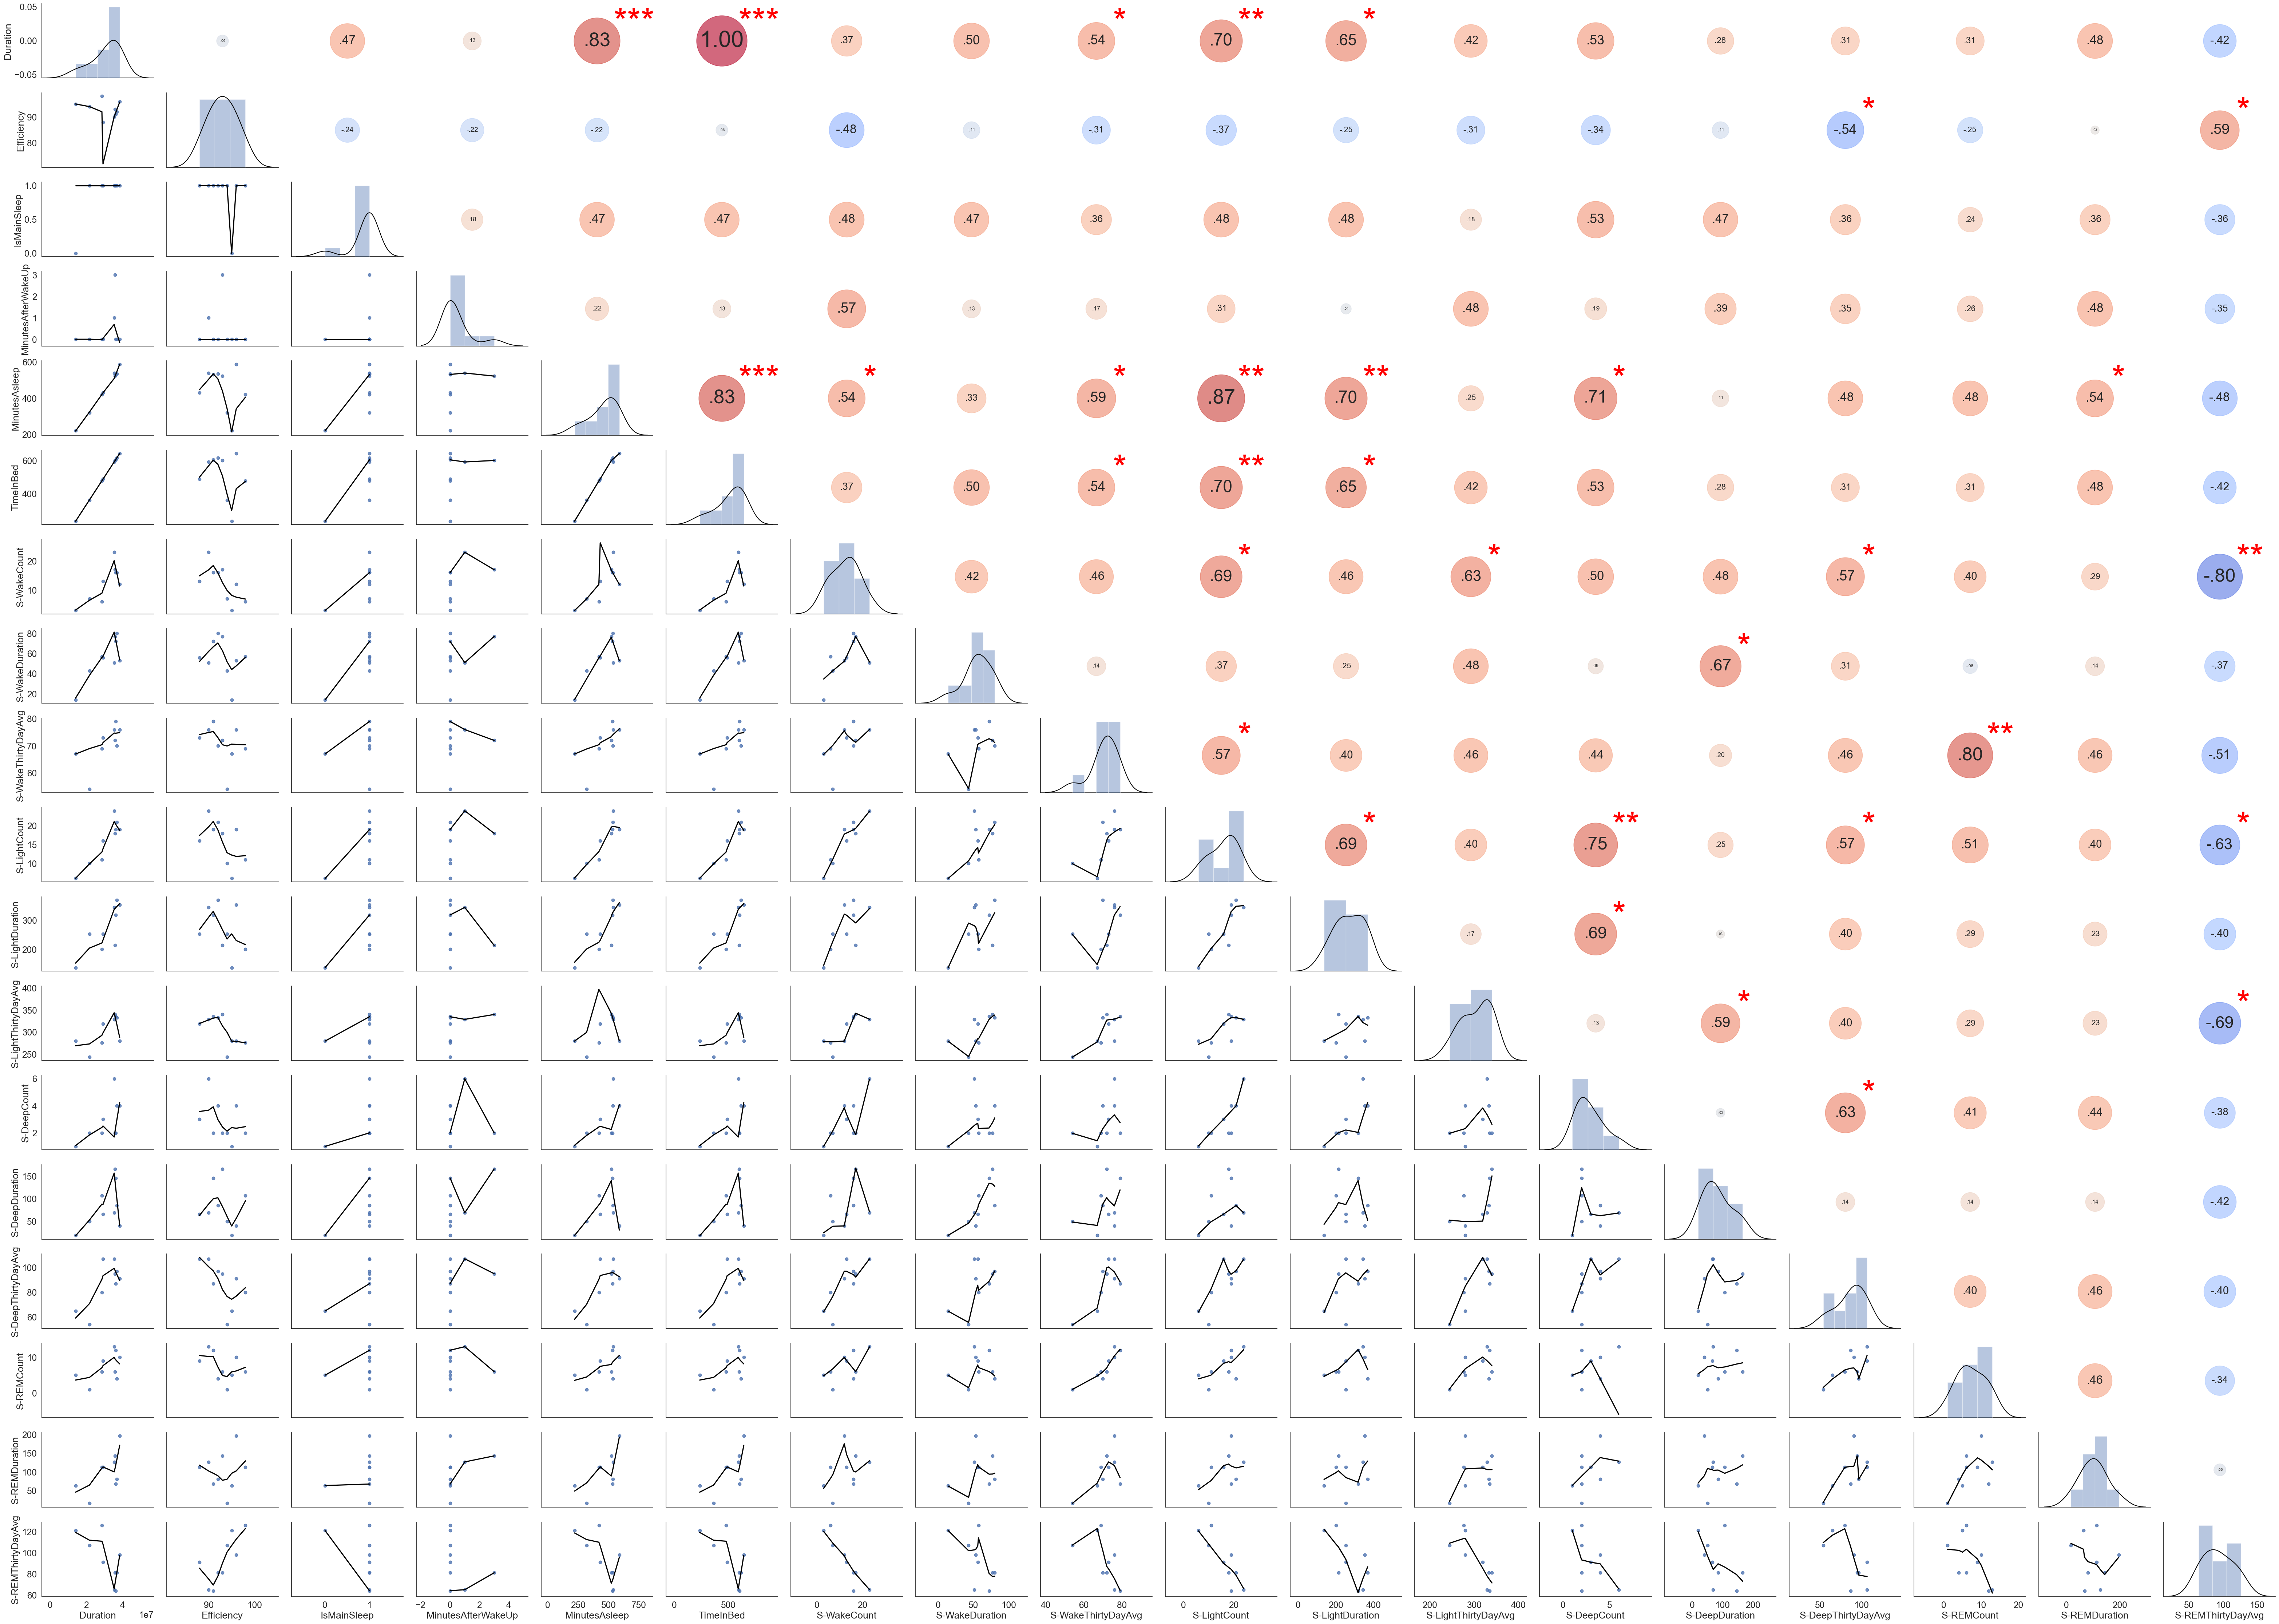

In [17]:
# let's see how well pairwise combinations of stages features correlate with each other
pt_sleep_wear_scatter_stages = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]].dropna()

plotcorr(pt_sleep_wear_scatter_stages)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_stages"))

plt.show()

In [18]:
# let's see if we can use general features to separate the data into high sleep and low sleep
pt_sleep_wear_scatter_clustered = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9]]

# let's Z score each column across all the instances in our dataset to deal with outliers better
pt_sleep_wear_scatter_clustered = pd.DataFrame(StandardScaler().fit_transform(pt_sleep_wear_scatter_clustered), columns = pt_sleep_wear_scatter_clustered.columns)

# we will use a hierarchical clustering algorithm (hierarchical DBSCAN)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(pt_sleep_wear_scatter_clustered)

pt_sleep_wear_scatter_clustered["cluster"] = cluster_labels.tolist()

In [19]:
# let's see the first 5 rows of the clustering results
pt_sleep_wear_scatter_clustered.head()

Duration  Efficiency  IsMainSleep  MinutesAfterWakeUp  MinutesAsleep  \
0  1.165008   -0.630661     0.738549           -0.392837       1.132135   
1 -1.253976   -0.051135    -1.354006           -0.392837      -1.262815   
2 -1.301688   -0.630661    -1.354006           -0.392837      -1.322418   
3  1.102983   -0.920425     0.738549            0.942809       1.175483   
4  1.217491   -0.340898     0.738549           -0.392837       1.148391   

   TimeInBed  cluster  
0   1.165008       -1  
1  -1.253976       -1  
2  -1.301688       -1  
3   1.102983       -1  
4   1.217491       -1

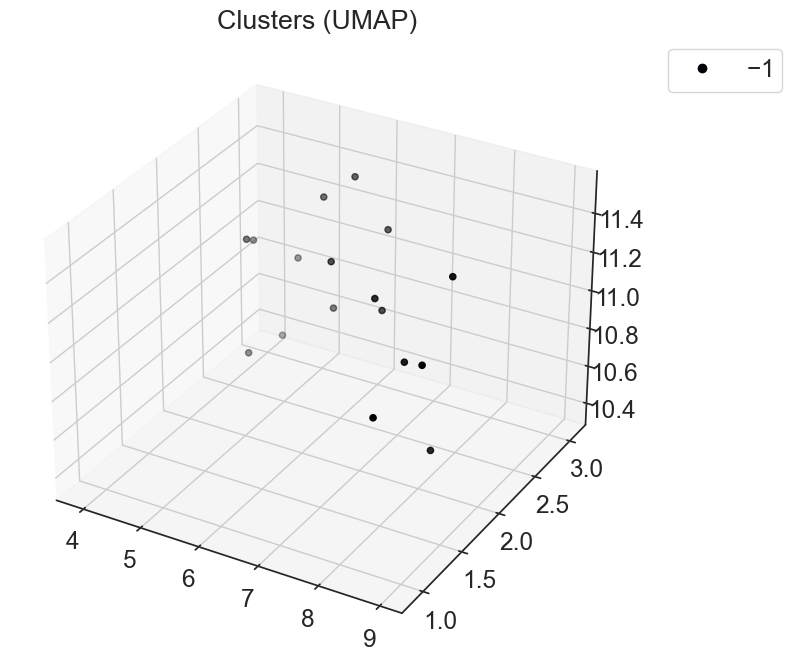

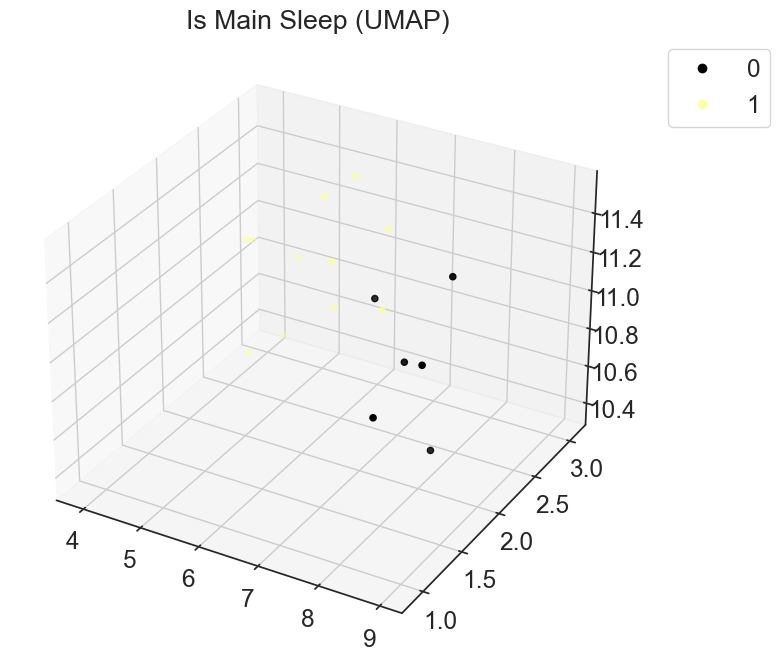

In [20]:
# let's visualize clusters and IsMainSleep in 3D using UMAP for nonlinear dimensionality reduction
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9]]

umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_3d = umap_3d.fit_transform(pt_sleep_wear_scatter)

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
sc = ax.scatter3D(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Clusters (UMAP)")

save_fig((pt_id + "_clusters_umap"))

# show plot
plt.show()

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
sc = ax.scatter3D(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=pt_sleep_wear["IsMainSleep"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Is Main Sleep (UMAP)")

save_fig((pt_id + "_is_main_sleep_umap"))

# show plot
plt.show()

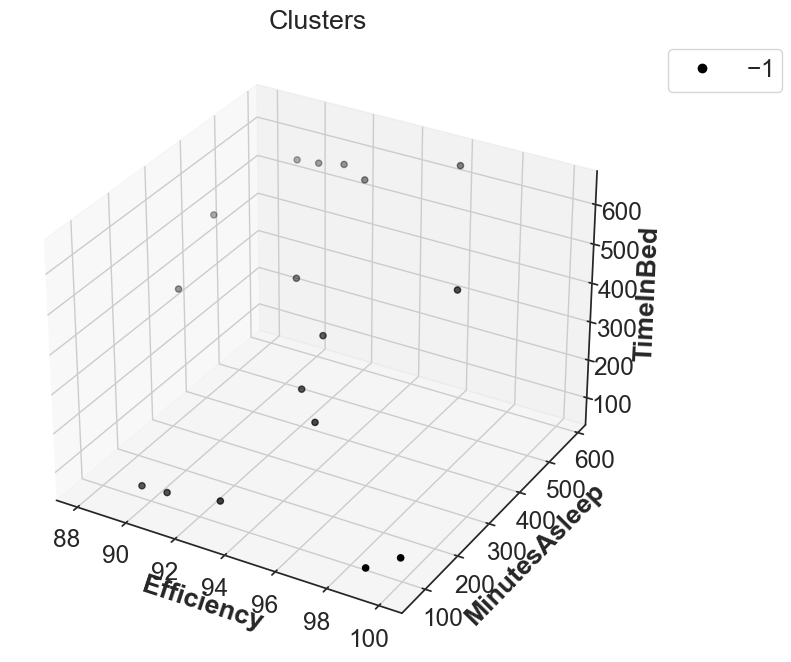

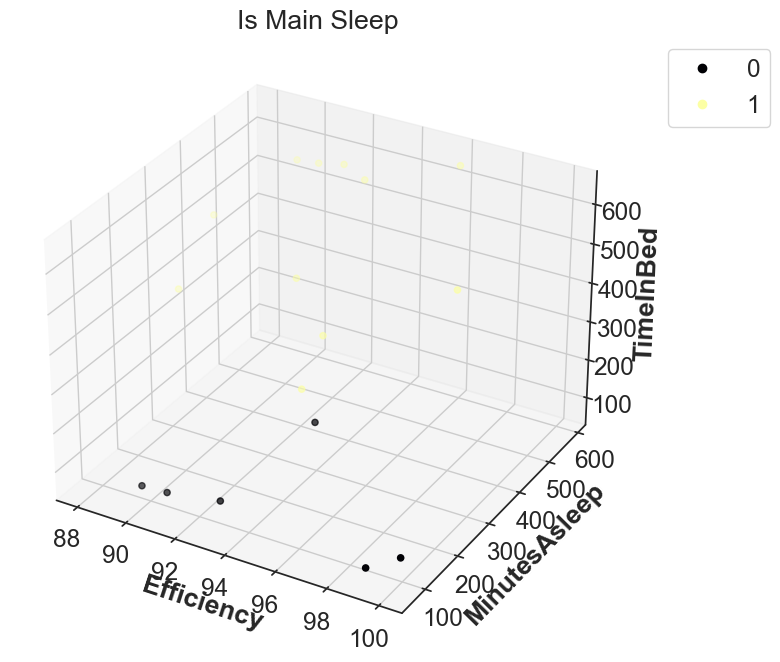

In [21]:
# let's visualize the clustering results in a 3D scatter plot with more concrete axes
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [3, 7, 9]].to_numpy()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Clusters")

ax.set_xlabel(pt_sleep_wear.columns[3], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[9], fontweight ='bold')

save_fig((pt_id + "_clusters_3D_efficiency"))

# show plot
plt.show()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear["IsMainSleep"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Is Main Sleep")

ax.set_xlabel(pt_sleep_wear.columns[3], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[9], fontweight ='bold')

save_fig((pt_id + "_is_main_sleep_3D_efficiency"))

# show plot
plt.show()

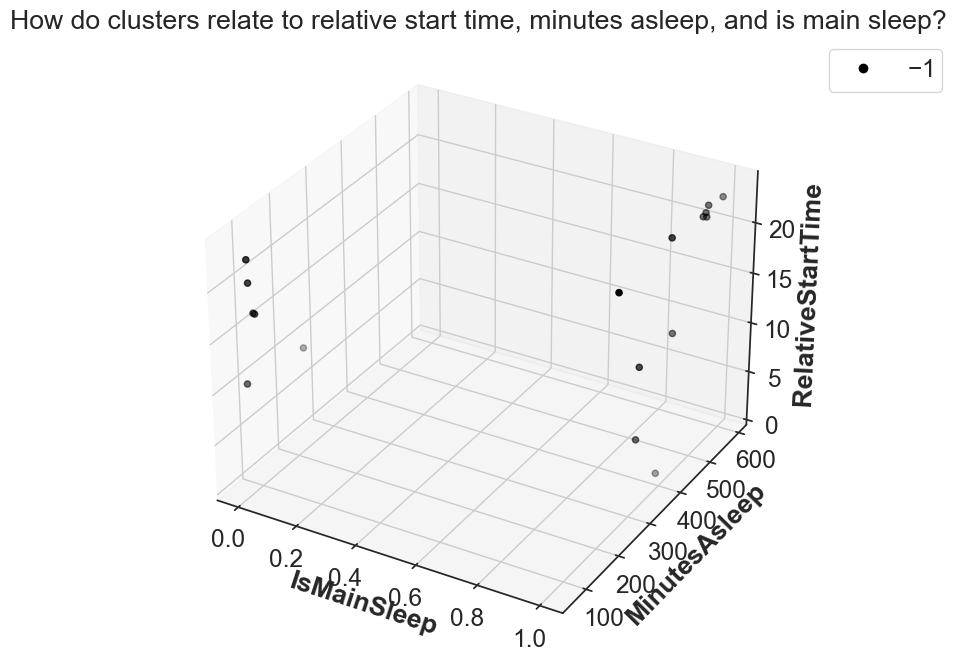

In [22]:
# How do clusters relate to relative start time, minutes asleep, and is main sleep?
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [4, 7, 31]].to_numpy()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("How do clusters relate to relative start time, minutes asleep, and is main sleep?")

ax.set_xlabel(pt_sleep_wear.columns[4], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[31], fontweight ='bold')

save_fig((pt_id + "_clusters_3D_relative_start_time"))

plt.show()

In [23]:
# let's calculate cluster fingerprints to see 
# if the clusters actually represent high and low sleep based on objective metrics
minClusterIndex = 0
maxClusterIndex = pt_sleep_wear_scatter_clustered["cluster"].max()

clusterFingerPrintsMeanZScore = pd.DataFrame()
clusterFingerPrintsStdZScore = pd.DataFrame()

for i in range(maxClusterIndex + 1):
    rowsOfInterest = pt_sleep_wear_scatter_clustered[pt_sleep_wear_scatter_clustered["cluster"] == i]
    
    clusterFingerPrintsMeanZScore["Cluster " + str(i)] = rowsOfInterest.loc[:, rowsOfInterest.columns != "cluster"].mean(axis=0)
    clusterFingerPrintsStdZScore["Cluster " + str(i)] = rowsOfInterest.loc[:, rowsOfInterest.columns != "cluster"].std(axis=0)

In [24]:
# plotting correlation heatmap
sns.heatmap(clusterFingerPrintsMeanZScore).set(title="Mean Z Scores")

save_fig((pt_id + "_cluster_fingerprints_mean_z_score"))

plt.show() 

sns.heatmap(clusterFingerPrintsStdZScore).set(title="Standard Deviation Z Scores")  

save_fig((pt_id + "_cluster_fingerprints_std_z_score"))

plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity